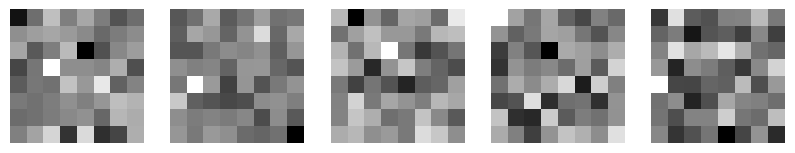

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import digamma, betaln

# Параметры модели
N = 1000  # Количество данных
D = 64   # Размерность данных (например, число пикселей)
K = 5   # Максимальное количество кластеров
alpha = 1.0
a, b = 1.0, 1.0

# Функция для инициализации параметров q
def initialize_q():
    q_Z = np.random.dirichlet(np.ones(K), N)  # Категориальные распределения
    q_theta = np.random.beta(a, b, (K, D))  # Параметры Бернулли
    q_v = np.random.beta(1, alpha, K)  # Параметры разбиения палки
    return q_Z, q_theta, q_v

# Функция для вычисления L(q) - вариационной нижней оценки
def compute_L(q_Z, q_theta, q_v, X):
    # Вычисляем все необходимые термы
    L = 0

    # 1. Вычисляем ожидаемую вероятность данных
    for n in range(N):
        for k in range(K):
            log_p_x_given_theta = np.sum(X[n] * np.log(q_theta[k] + 1e-10) +
                                         (1 - X[n]) * np.log(1 - q_theta[k] + 1e-10))
            L += q_Z[n, k] * log_p_x_given_theta

    # 2. Вычисляем энтропию q(Z)
    L += np.sum(q_Z * np.log(q_Z + 1e-10))

    # 3. Добавляем термы, связанные с q(v) (разбиение палки)
    L += np.sum((1 - q_v) * (digamma(alpha + 1) - digamma(alpha)))

    # 4. Добавляем термы, связанные с q(theta) (бета-распределения)
    L += np.sum((a - 1) * np.log(q_theta + 1e-10) + (b - 1) * np.log(1 - q_theta + 1e-10))

    return L

# Обновление параметров q
def update_parameters(X, q_Z, q_theta, q_v):
    # Обновление q(Z)
    for n in range(N):
        for k in range(K):
            log_p_x_given_theta = np.sum(X[n] * np.log(q_theta[k] + 1e-10) +
                                         (1 - X[n]) * np.log(1 - q_theta[k] + 1e-10))
            q_Z[n, k] = np.exp(log_p_x_given_theta)

        # Нормализация
        q_Z[n] /= np.sum(q_Z[n])

    # Обновление q(theta)
    for k in range(K):
        for d in range(D):
            q_theta[k, d] = (a + np.sum(X[:, d] * q_Z[:, k])) / (a + b + N)

    # Обновление q(v)
    for k in range(K):
        q_v[k] = (1 + np.sum(q_Z[:, k])) / (alpha + N)

    return q_Z, q_theta, q_v

# Основной алгоритм вариационного вывода
def variational_inference(X, num_starts=5):
    best_L = -np.inf
    best_q = None

    for _ in range(num_starts):
        q_Z, q_theta, q_v = initialize_q()
        L = compute_L(q_Z, q_theta, q_v, X)

        # Основной цикл обновления параметров
        for _ in range(100):  # Число итераций
            q_Z, q_theta, q_v = update_parameters(X, q_Z, q_theta, q_v)
            new_L = compute_L(q_Z, q_theta, q_v, X)

            # Проверка на улучшение и обновление
            if new_L > L:
                L = new_L
            else:
                break

        # Сохраняем лучшее приближение q
        if L > best_L:
            best_L = L
            best_q = (q_Z, q_theta, q_v)

    return best_q, best_L

# Генерация случайных данных X для тестирования
X = np.random.binomial(1, 0.5, (N, D))

# Запуск алгоритма
best_q, best_L = variational_inference(X)

# Визуализация центров кластеров
q_Z, q_theta, q_v = best_q
centers = q_theta[:K]
plt.figure(figsize=(10, 2))
for i, center in enumerate(centers):
    plt.subplot(1, K, i + 1)
    plt.imshow(center.reshape(8, 8), cmap='gray')
    plt.axis('off')
plt.show()


Testing with alpha=0.5, a=0.1, b=0.1


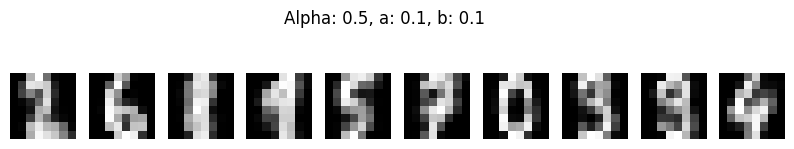

Accuracy: 0.7312
Testing with alpha=0.5, a=0.1, b=0.2


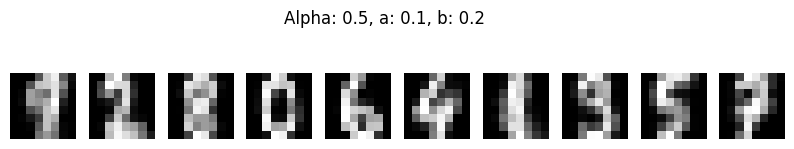

Accuracy: 0.7568
Testing with alpha=0.5, a=0.1, b=0.3


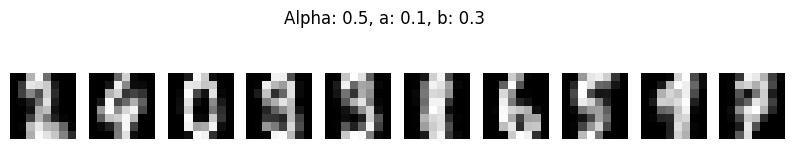

Accuracy: 0.7307
Testing with alpha=0.5, a=0.5, b=0.1


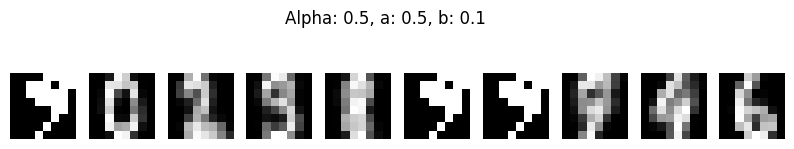

C:\Users\normist\AppData\Local\Temp\ipykernel_6908\3888906290.py:77: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y[mask])[0]


Accuracy: 0.5993
Testing with alpha=0.5, a=0.5, b=0.2


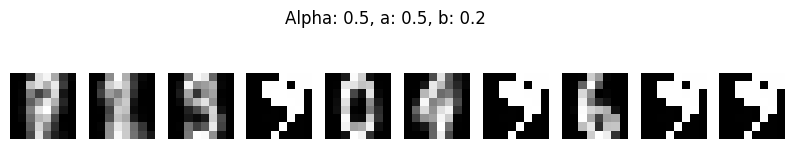

C:\Users\normist\AppData\Local\Temp\ipykernel_6908\3888906290.py:77: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y[mask])[0]


Accuracy: 0.5409
Testing with alpha=0.5, a=0.5, b=0.3


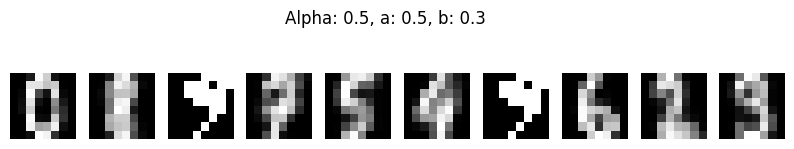

C:\Users\normist\AppData\Local\Temp\ipykernel_6908\3888906290.py:77: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y[mask])[0]


Accuracy: 0.6856
Testing with alpha=0.5, a=0.6, b=0.1


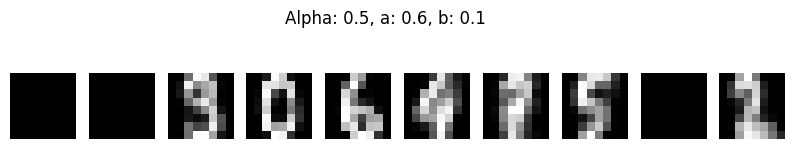

C:\Users\normist\AppData\Local\Temp\ipykernel_6908\3888906290.py:77: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y[mask])[0]


Accuracy: 0.6166
Testing with alpha=0.5, a=0.6, b=0.2


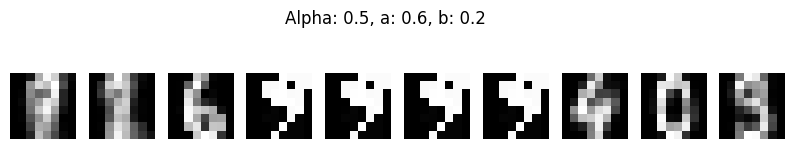

C:\Users\normist\AppData\Local\Temp\ipykernel_6908\3888906290.py:77: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y[mask])[0]


Accuracy: 0.5364
Testing with alpha=0.5, a=0.6, b=0.3


KeyboardInterrupt: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import Binarizer
from sklearn.metrics import accuracy_score
from scipy.special import digamma
from scipy.stats import mode

# Загружаем данные из набора Digits
digits = load_digits()
X = digits.data
y = digits.target  # Истинные метки классов
X = Binarizer(threshold=8).transform(X)  # Бинаризация данных (порог 8)

# Параметры модели
N, D = X.shape
K = 10  # Максимальное количество кластеров

# Функция для инициализации параметров q
def initialize_q(a, b, alpha):
    q_Z = np.random.dirichlet(np.ones(K), N)  # Категориальные распределения
    q_theta = np.random.beta(a, b, (K, D))  # Параметры Бернулли
    q_v = np.random.beta(1, alpha, K)  # Параметры разбиения палки
    return q_Z, q_theta, q_v

# Обновления параметров q с использованием digamma
def update_parameters(X, q_Z, q_theta, q_v, a, b, alpha):
    # Обновление q(Z)
    for n in range(N):
        for k in range(K):
            log_p_x_given_theta = np.sum(X[n] * np.log(q_theta[k] + 1e-10) +
                                         (1 - X[n]) * np.log(1 - q_theta[k] + 1e-10))
            q_Z[n, k] = np.exp(log_p_x_given_theta)
        q_Z[n] /= np.sum(q_Z[n])  # Нормализация

    # Обновление q(theta)
    for k in range(K):
        for d in range(D):
            q_theta[k, d] = (a + np.sum(X[:, d] * q_Z[:, k])) / (a + b + np.sum(q_Z[:, k]))

    # Обновление q(v) с использованием digamma
    for k in range(K):
        c_k = 1 + np.sum(q_Z[:, k])
        d_k = alpha + np.sum(np.sum(q_Z[:, (k+1):]))
        q_v[k] = np.exp(digamma(c_k) - digamma(c_k + d_k))

    return q_Z, q_theta, q_v

# Основной цикл вариационного вывода
def variational_inference(X, alpha, a, b, num_iterations=50):
    q_Z, q_theta, q_v = initialize_q(a, b, alpha)
    for _ in range(num_iterations):
        q_Z, q_theta, q_v = update_parameters(X, q_Z, q_theta, q_v, a, b, alpha)
    return q_Z, q_theta, q_v

# Функция для тестирования алгоритма с разными параметрами
def test_parameters(alpha, a, b):
    q_Z, q_theta, q_v = variational_inference(X, alpha, a, b)
    centers = q_theta[:K]

    # Визуализация центров кластеров
    plt.figure(figsize=(10, 2))
    for i, center in enumerate(centers):
        plt.subplot(1, K, i + 1)
        plt.imshow(center.reshape(8, 8), cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Alpha: {alpha}, a: {a}, b: {b}")
    plt.show()

    # Определение меток кластеров на основе максимального значения q(Z)
    predicted_labels = np.argmax(q_Z, axis=1)

    # Сопоставление кластеров с истинными метками
    labels = np.zeros_like(predicted_labels)
    for i in range(K):
        mask = (predicted_labels == i)
        labels[mask] = mode(y[mask])[0]

    # Оценка точности
    accuracy = accuracy_score(y, labels)
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy


alphas = [0.5, 0.6, 0.7]  # Увеличим alpha
a_values = [0.1, 0.5, 0.6]  # Изменим параметры a
b_values = [ 0.1, 0.2, 0.3]  # Изменим параметры b

mass = []
for alpha in alphas:
    for a in a_values:
        for b in b_values:
            print(f"Testing with alpha={alpha}, a={a}, b={b}")
            acc = test_parameters(alpha, a, b)
            mass.append([acc, [alpha, a, b]])

max_acc = 0
best_param=[]
for i in mass:
    if max_acc < i[0]:
        max_acc = i[0]
        best_param = i[1]

print(max_acc)
print(best_param)

In [3]:
K = 10  # Максимальное количество кластеров
# alpha, a, b = 10, 2, 5  # Лучшие найденные параметры
alpha=0.6
a=0.1
b=0.3

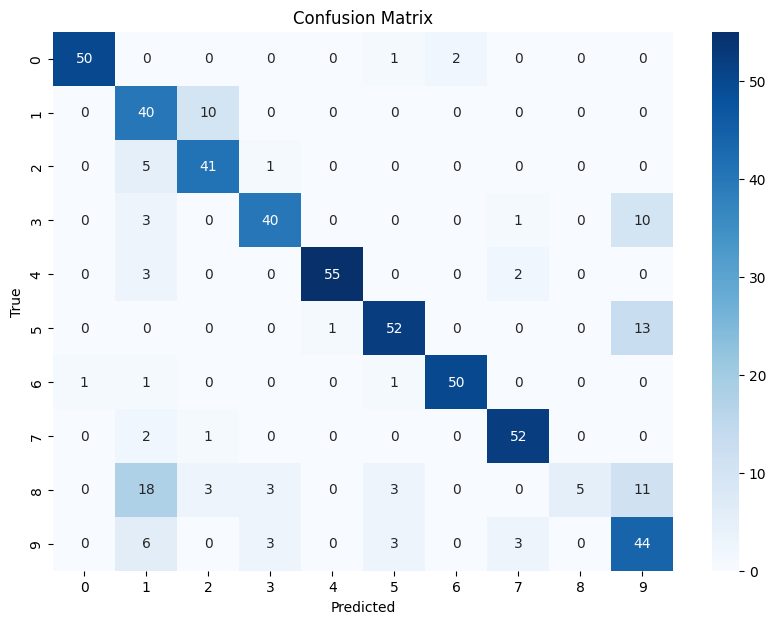

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        53
           1       0.51      0.80      0.62        50
           2       0.75      0.87      0.80        47
           3       0.85      0.74      0.79        54
           4       0.98      0.92      0.95        60
           5       0.87      0.79      0.83        66
           6       0.96      0.94      0.95        53
           7       0.90      0.95      0.92        55
           8       1.00      0.12      0.21        43
           9       0.56      0.75      0.64        59

    accuracy                           0.79       540
   macro avg       0.84      0.78      0.77       540
weighted avg       0.84      0.79      0.78       540



In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Загружаем данные из набора Digits
digits = load_digits()
X = digits.data
y = digits.target  # Метки классов (цифры от 0 до 9)
X = Binarizer(threshold=8).transform(X)  # Бинаризация данных

# Параметры модели
N, D = X.shape

# Функция для инициализации параметров q
def initialize_q():
    q_Z = np.random.dirichlet(np.ones(K), N)
    q_theta = np.random.beta(a, b, (K, D))
    q_v = np.random.beta(1, alpha, K)
    return q_Z, q_theta, q_v

# Обновления параметров q
def update_parameters(X, q_Z, q_theta, q_v):
    for n in range(N):
        for k in range(K):
            log_p_x_given_theta = np.sum(X[n] * np.log(q_theta[k] + 1e-10) +
                                         (1 - X[n]) * np.log(1 - q_theta[k] + 1e-10))
            q_Z[n, k] = np.exp(log_p_x_given_theta)
        q_Z[n] /= np.sum(q_Z[n])  # Нормализация

    for k in range(K):
        for d in range(D):
            q_theta[k, d] = (a + np.sum(X[:, d] * q_Z[:, k])) / (a + b + np.sum(q_Z[:, k]))

    for k in range(K):
        c_k = 1 + np.sum(q_Z[:, k])
        d_k = alpha + np.sum(np.sum(q_Z[:, (k+1):]))
        q_v[k] = np.exp(digamma(c_k) - digamma(c_k + d_k))

    return q_Z, q_theta, q_v

# Основной цикл вариационного вывода
def variational_inference(X, num_iterations=50):
    q_Z, q_theta, q_v = initialize_q()
    for _ in range(num_iterations):
        q_Z, q_theta, q_v = update_parameters(X, q_Z, q_theta, q_v)
    return q_Z

# Запуск вариационного вывода
q_Z = variational_inference(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(q_Z, y, test_size=0.3, random_state=42)

# Обучение классификатора (логистическая регрессия)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Оценка на тестовой выборке
y_pred = classifier.predict(X_test)

# Построение матрицы точности
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Печать отчета о классификации
print(classification_report(y_test, y_pred))

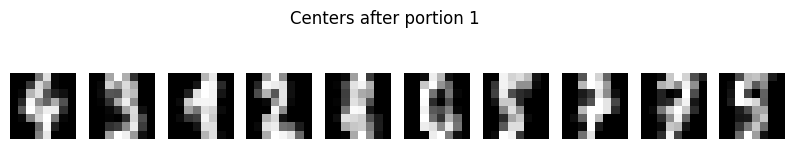

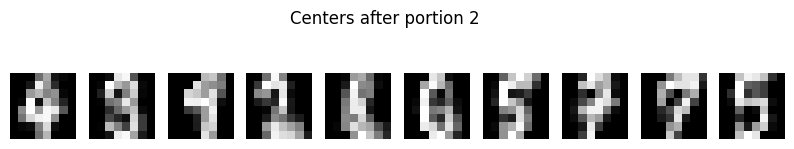

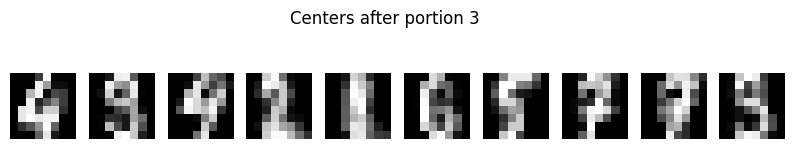

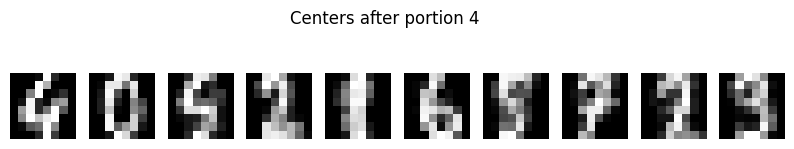

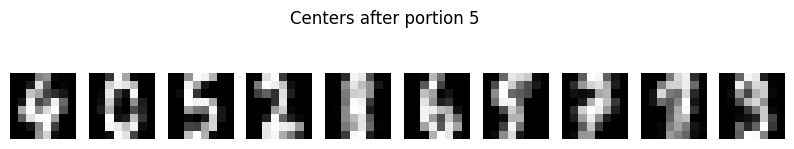

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import Binarizer
from sklearn.metrics import accuracy_score
from scipy.special import digamma
from scipy.stats import mode

# Загружаем данные из набора Digits
digits = load_digits()
X = digits.data
y = digits.target  # Истинные метки классов
X = Binarizer(threshold=8).transform(X)  # Бинаризация данных (порог 8)

# Параметры модели
N, D = X.shape


# Функция для инициализации параметров q
def initialize_q():
    q_Z = np.random.dirichlet(np.ones(K), N)  # Категориальные распределения
    q_theta = np.random.beta(a, b, (K, D))  # Параметры Бернулли
    q_v = np.random.beta(1, alpha, K)  # Параметры разбиения палки
    return q_Z, q_theta, q_v

# Обновления параметров q с использованием digamma
def update_parameters(X, q_Z, q_theta, q_v):
    N = X.shape[0]  # Обновляем N в зависимости от размера текущей порции данных
    for n in range(N):
        for k in range(K):
            log_p_x_given_theta = np.sum(X[n] * np.log(q_theta[k] + 1e-10) +
                                         (1 - X[n]) * np.log(1 - q_theta[k] + 1e-10))
            q_Z[n, k] = np.exp(log_p_x_given_theta)
        q_Z[n] /= np.sum(q_Z[n])  # Нормализация

    # Обновление q(theta)
    for k in range(K):
        for d in range(D):
            q_theta[k, d] = (a + np.sum(X[:, d] * q_Z[:, k])) / (a + b + np.sum(q_Z[:, k]))

    # Обновление q(v) с использованием digamma
    for k in range(K):
        c_k = 1 + np.sum(q_Z[:, k])
        d_k = alpha + np.sum(np.sum(q_Z[:, (k+1):]))
        q_v[k] = np.exp(digamma(c_k) - digamma(c_k + d_k))

    return q_Z, q_theta, q_v

# Основной цикл вариационного вывода с поступлением данных порциями
def variational_inference_online(X, num_portions=5, num_iterations=500):
    q_Z, q_theta, q_v = initialize_q()
    portion_size = N // num_portions

    for portion in range(num_portions):
        q_Z, g, q_v = initialize_q()
        start = portion * portion_size
        end = (portion + 1) * portion_size if portion != num_portions - 1 else N
        X_portion = X[start:end]

        # Обновляем параметры для текущей порции данных
        for _ in range(num_iterations):
            q_Z[start:end], q_theta, q_v = update_parameters(X_portion, q_Z[start:end], q_theta, q_v)

        # Визуализация центров кластеров после обработки порции данных
        centers = q_theta[:K]
        plt.figure(figsize=(10, 2))
        for i, center in enumerate(centers):
            plt.subplot(1, K, i + 1)
            plt.imshow(center.reshape(8, 8), cmap='gray')
            plt.axis('off')
        plt.suptitle(f"Centers after portion {portion + 1}")
        plt.show()

# Запуск онлайн-обучения с поступлением данных порциями
variational_inference_online(X)
